In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# append source
import os, sys

partial_equiv_source = os.path.join(os.getcwd(), '..')
if partial_equiv_source not in sys.path:
    sys.path.append(partial_equiv_source)

from partial_equiv.partial_gconv.conv import LiftingConv, GroupConv
import partial_equiv.groups as groups

# visualization_utilities
from visualization_utils import (
    visualize_lifting_coordinate_grids, visualize_lifting_kernels,
    visualize_group_coordinate_grids, visualize_group_kernels,
    visualize_activations,
)

In [3]:
device = 'cpu'
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
from omegaconf import OmegaConf

# Get the template of the config file used in the experiments
config_template = OmegaConf.load(os.path.join(partial_equiv_source, 'cfg/config.yaml'))

# Get templates of the config files for the group, kernel and conv.
group_config = config_template.base_group
kernel_config = config_template.kernel
conv_config = config_template.conv

In [5]:
# Modify them

# Group
group_config.no_samples = 7
group_config.sampling_method = groups.SamplingMethods.DETERMINISTIC
print(OmegaConf.to_yaml(group_config))

# Kernel
kernel_config.type = "SIREN"
kernel_config.no_hidden = 32
kernel_config.no_layers = 3
kernel_config.size = "7"
kernel_config.omega0 = 10.0
print(OmegaConf.to_yaml(kernel_config))

# Conv
conv_config.padding = "same"
conv_config.partial_equiv = False
print(OmegaConf.to_yaml(conv_config))

name: ''
no_samples: 7
sample_per_batch_element: false
sample_per_layer: false
sampling_method: DETERMINISTIC
gumbel_init_temp: 0.5
gumbel_end_temp: 0.0001

type: SIREN
no_hidden: 32
no_layers: 3
size: '7'
omega0: 10.0
learn_omega0: false
weight_norm: false

padding: same
partial_equiv: false
bias: true



In [6]:
group = groups.SE2()

liftconv = LiftingConv(
    in_channels=1,
    out_channels=20,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)

gconv = GroupConv(
    in_channels=20,
    out_channels=5,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)
liftconv, gconv = liftconv.to(device), gconv.to(device)

In [8]:
x = torch.rand([50, 1, 21, 21], device=device)

In [9]:
out_lift, g_elems = liftconv(x)
out_group = gconv([out_lift, g_elems])

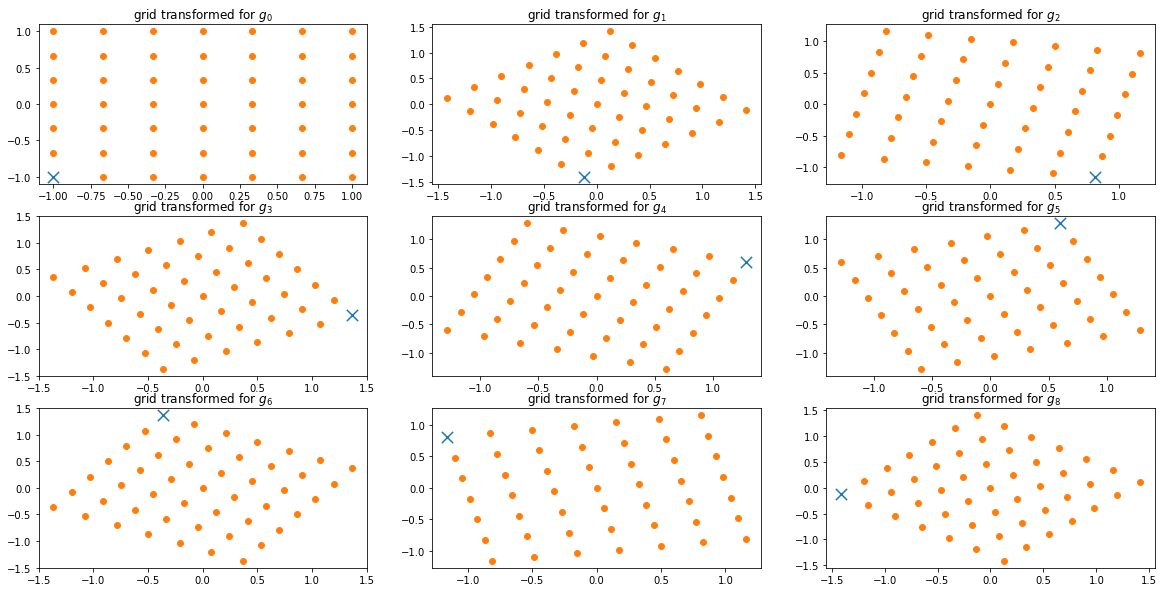

In [11]:
visualize_lifting_coordinate_grids(liftconv.acted_rel_pos)

In [10]:
def visualize_group_kernels(kernels, save_name=None):
    no_group_elements_out = len(kernels)
    no_out_channels = kernels[0].shape[0]
    no_in_channels = kernels[0].shape[1]
    kernel_size = kernels[0].shape[-1]

    xx, yy = np.meshgrid(
        np.linspace(-1, 1, num=kernel_size), np.linspace(-1, 1, num=kernel_size)
    )

    for out_channel in range(no_out_channels):

        fig = plt.figure()
        fig_idx = 0
        for in_channel in range(no_in_channels):

            for group_elem_out in range(no_group_elements_out):
                filt = kernels[group_elem_out][out_channel, in_channel, :, :, :]
                catfilt = np.concatenate([f for f in filt], axis=0)

                ax = fig.add_subplot(no_in_channels, no_group_elements_out, fig_idx + 1)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(catfilt)
                #ax.set_title(f"$C^{in_channel}_{out_channel} g_{group_elem_out}$")
                fig_idx += 1
    
    plt.tight_layout()
                
    if save_name is not None:
        plt.savefig(save_name, dpi=300)

    plt.show()

tensor([[0.0000, 0.8976, 1.7952, 2.6928, 3.5904, 4.4880, 5.3856]],
       dtype=torch.float64)

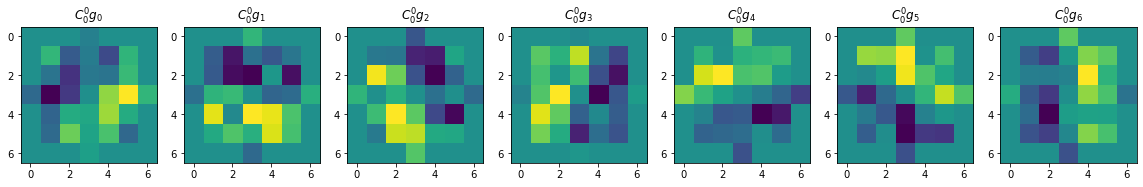

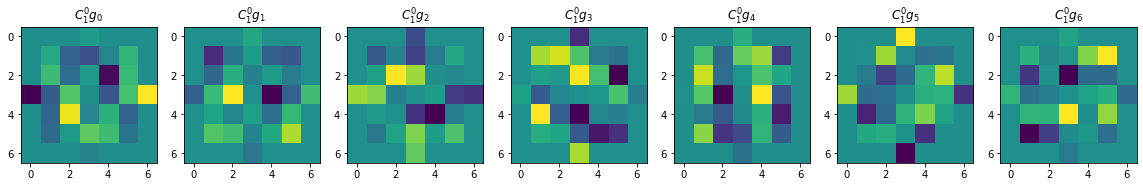

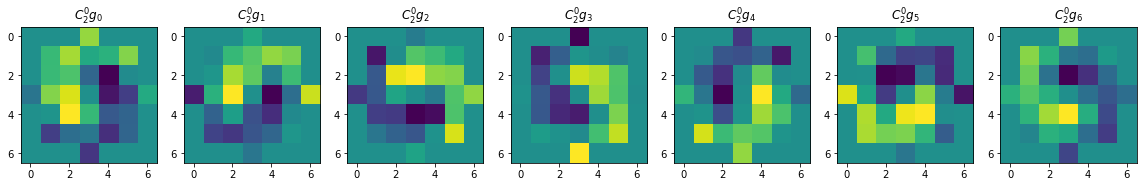

In [11]:
visualize_lifting_kernels(liftconv.conv_kernel[:, :3, :1, :, :].detach())
liftconv.conv_kernel.shape
g_elems

ValueError: num must be 1 <= num <= 9, not 10

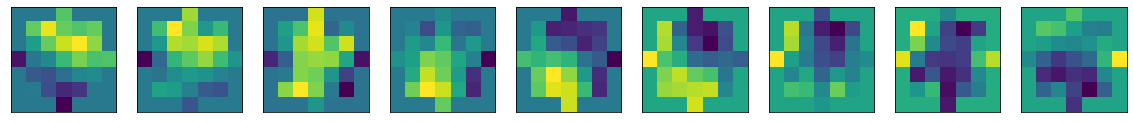

In [ ]:
visualize_group_kernels(gconv.conv_kernel[:, :1, :1, :, :].detach(), save_name="conv_kernels.png")

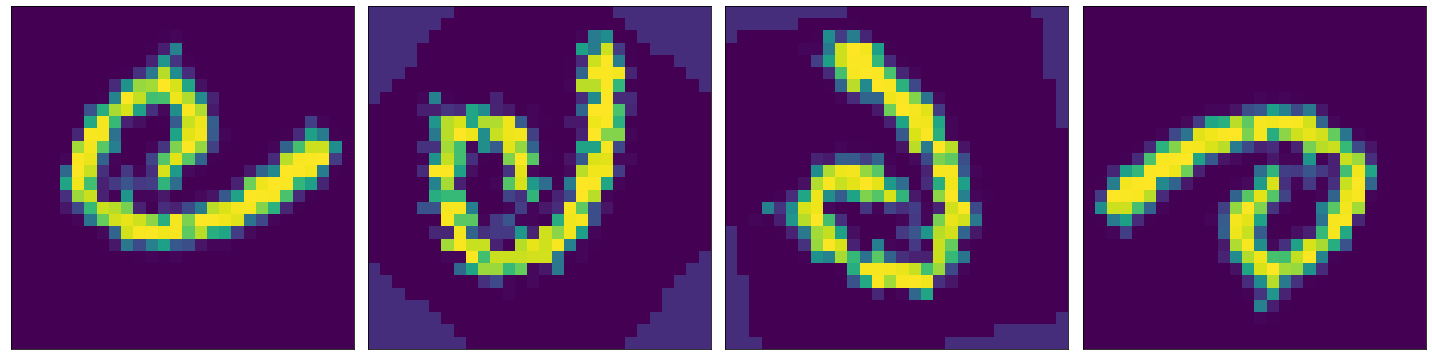

In [16]:
from datasets import RotatedMNIST
from torch.utils.data import Dataset, DataLoader

training_set = RotatedMNIST(
        partition="train",
        augment="None",
        root=os.path.join(os.path.dirname(os.getcwd()), "data"),
)

training_loader = DataLoader(
    training_set,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# obtain a set of samples
samples, _ = next(iter(training_loader))
# rotate the set of samples
samples_30 = TF.rotate(samples, 51.4)
samples_60 = TF.rotate(samples, 51.4 * 2)
samples_180 = TF.rotate(samples, 180)

no_rows = 1
no_cols = 3

fig = plt.figure()
ax_1 = fig.add_subplot(1, 4, 1)
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_1.imshow(samples[0, 0, :, :])
ax_1 = fig.add_subplot(1, 4, 2)
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_1.imshow(samples_30[0, 0, :, :])
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_1 = fig.add_subplot(1, 4, 3)
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_1.imshow(samples_60[0, 0, :, :])
ax_1 = fig.add_subplot(1, 4, 4)
ax_1.set_xticks([])
ax_1.set_yticks([])
ax_1.imshow(samples_180[0, 0, :, :])

plt.tight_layout()
plt.savefig("inputs.png", dpi=300)

plt.show()

In [85]:
lifting_conv_acts, grid_H = liftconv(samples)
lifting_conv_acts = torch.relu(lifting_conv_acts)
group_conv_acts, grid_H = gconv([lifting_conv_acts, grid_H])

In [86]:
lifting_conv_samples_30, grid_H = liftconv(samples_30)
lifting_conv_samples_30 = torch.relu(lifting_conv_samples_30)
group_conv_samples_30, grid_H = gconv([lifting_conv_samples_30, grid_H])

lifting_conv_samples_60, grid_H = liftconv(samples_60)
lifting_conv_samples_60 = torch.relu(lifting_conv_samples_60)
group_conv_samples_60, grid_H = gconv([lifting_conv_samples_60, grid_H])

lifting_conv_samples_180, grid_H = liftconv(samples_180)
lifting_conv_samples_180 = torch.relu(lifting_conv_samples_180)
group_conv_samples_180, grid_H = gconv([lifting_conv_samples_180, grid_H])

In [15]:
def visualize_activations(acts, channel_idx=0, sample_idx=0, save_name=None):
    """Visualize the activations throughout the network.
    :param acts: tensor of activations with shape [batch_dim, out_channels, group_dim, spatial_1, spatial_2]
    :param channel_idx: integer, determines which of the output channels to visualize over the groups
    :param sample_idx: integer, determines which of the samples to visualize for
    :return: None
    """
    act = acts[sample_idx, channel_idx, :, :, :]

    no_rows = 1
    no_cols = len(act)

    fig = plt.figure()

    for group_elem in range(len(act)):
        ax = fig.add_subplot(no_rows, no_cols, group_elem + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(act[group_elem, :, :])
        
        #ax.set_title(f"Activations for channel {channel_idx}, $g_{group_elem}$")
        
    plt.tight_layout()
    
    if save_name is not None:
        plt.savefig(save_name, dpi=300)

    plt.show()
    

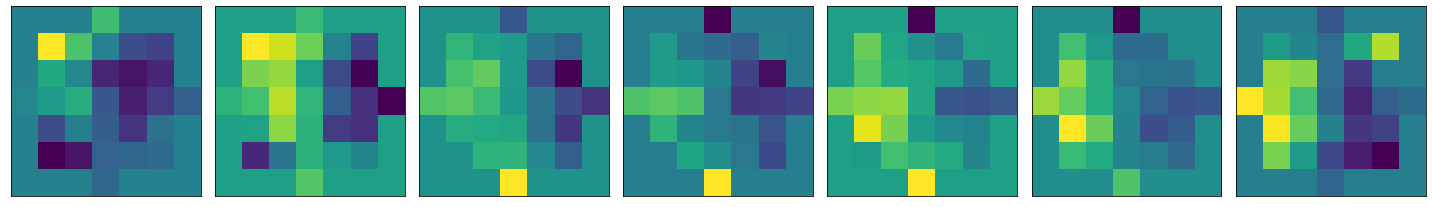

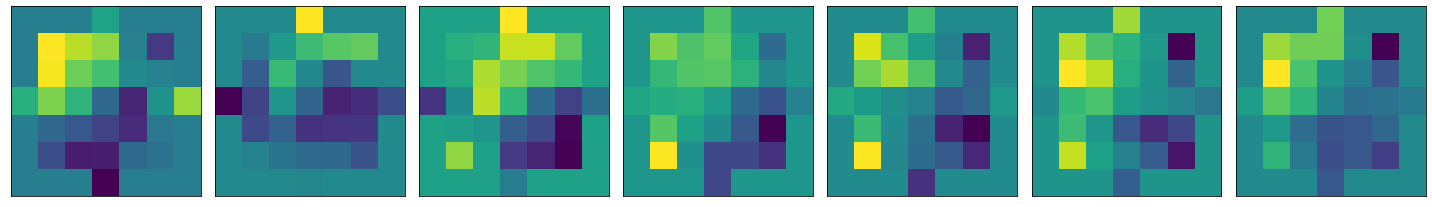

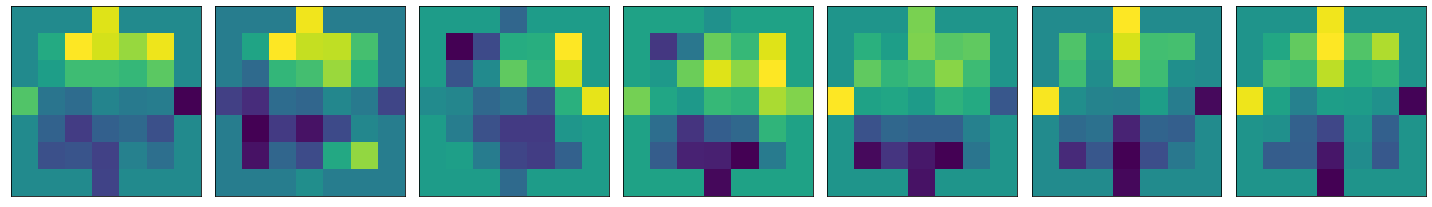

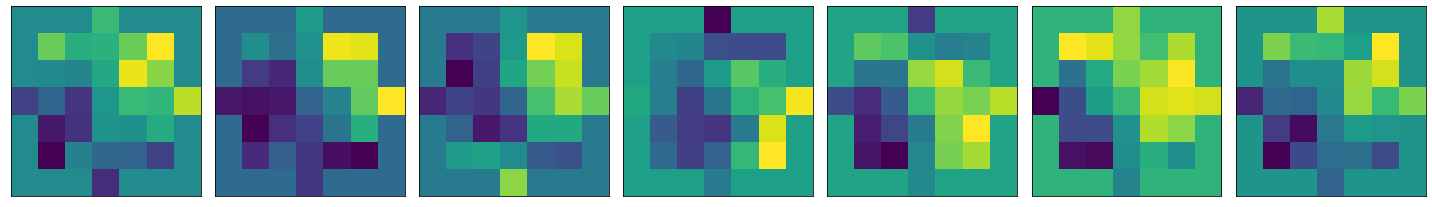

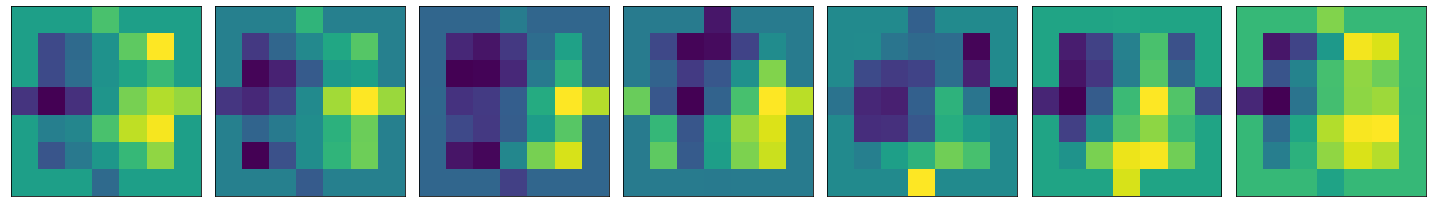

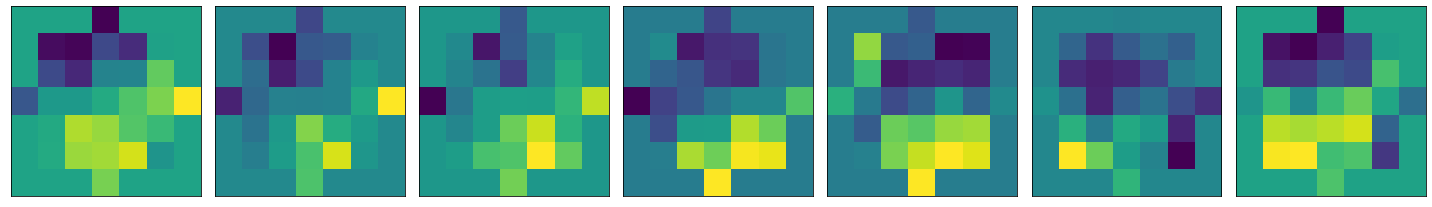

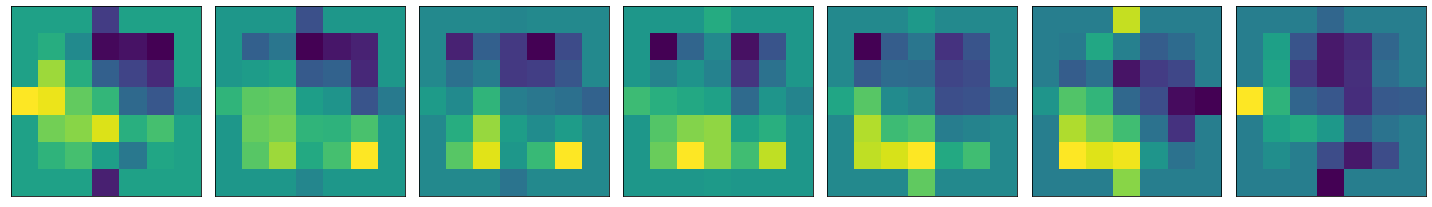

In [14]:
#gconv.conv_kernel.shape
for i in range(7):
    visualize_activations(gconv.conv_kernel[i].detach().numpy(), save_name=f"kernel_{i+1}.png")

# visualize_activations(lifting_conv_acts.detach().numpy(), save_name="activations_in.png")
# visualize_activations(group_conv_acts.detach().numpy(), save_name="activations_out.png")
# visualize_activations(group_conv_samples_30.roll(6, dims=2).detach().numpy())
# visualize_activations(group_conv_samples_60.roll(6, dims=2).detach().numpy())
# visualize_activations(group_conv_samples_180.roll(6, dims=2).detach().numpy())

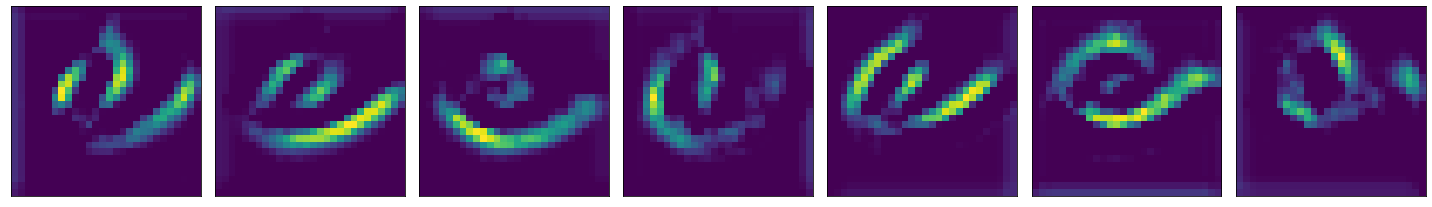

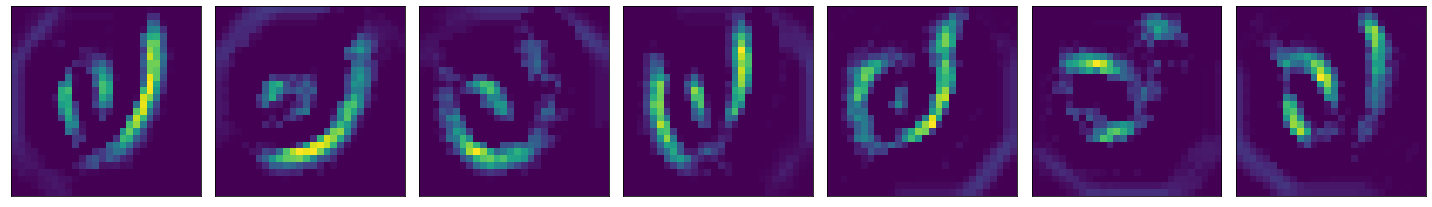

In [ ]:
visualize_activations(lifting_conv_acts.roll(4, dims=2).detach().numpy(), save_name="lift_0_rot.png")
visualize_activations(lifting_conv_samples_30.roll(4, dims=2).detach().numpy(), save_name="lift_30_rot.png")

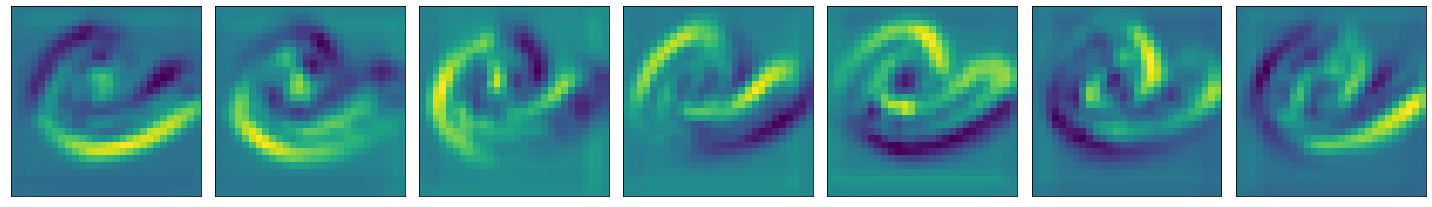

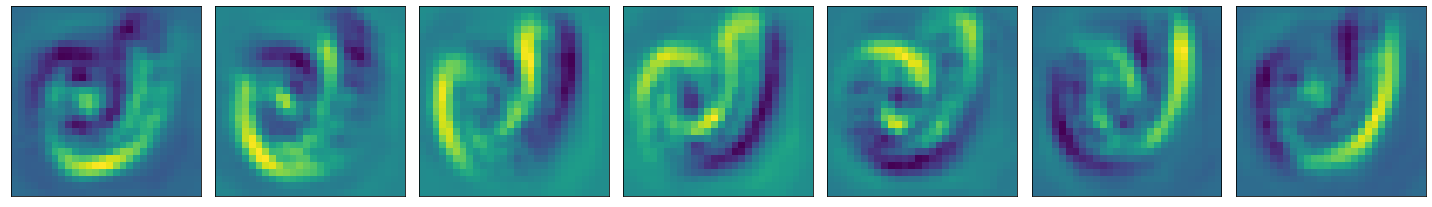

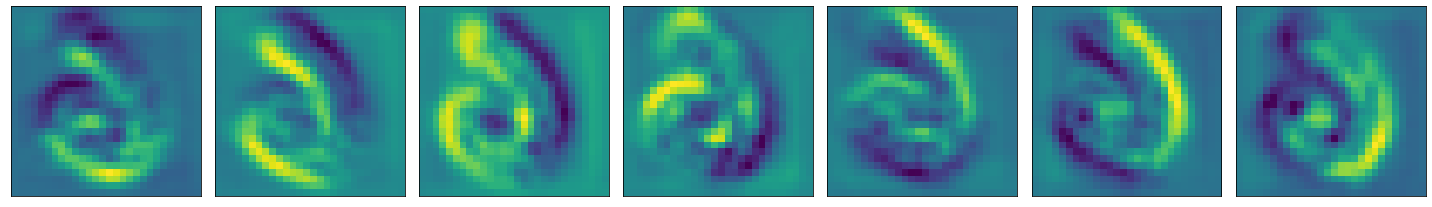

In [87]:
visualize_activations(group_conv_acts.roll(4, dims=2).detach().numpy(), save_name="0_rot.png")
visualize_activations(group_conv_samples_30.roll(4, dims=2).detach().numpy(), save_name="30_rot.png")
visualize_activations(group_conv_samples_60.roll(4, dims=2).detach().numpy(), save_name="60_rot.png")

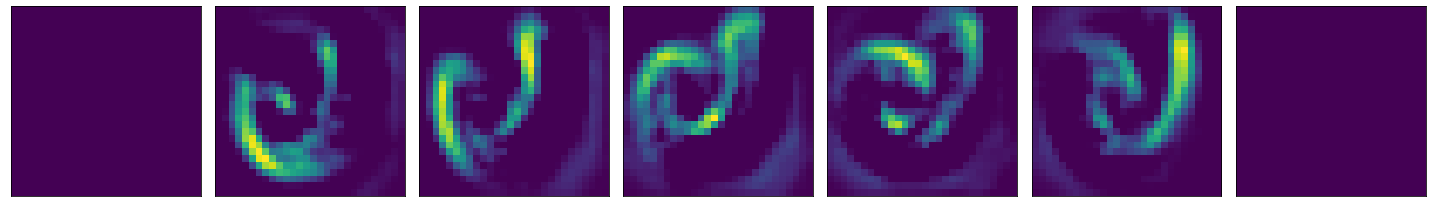

In [49]:
group_conv_acts[:,:,2:4] = 0
visualize_activations(group_conv_acts.roll(4, dims=2).detach().numpy())

In [80]:
gconv2 = GroupConv(
    in_channels=5,
    out_channels=5,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)

In [88]:
group_conv_acts = torch.relu(group_conv_acts)
group_conv_acts[:,:,2:4] = 0
group_conv_acts_2, grid_H = gconv2([group_conv_acts, grid_H])

group_conv_samples_30 = torch.relu(group_conv_samples_30)
group_conv_samples_30[:,:,2:4] = 0
group_conv_samples_30_2, _ = gconv2([group_conv_samples_30, grid_H])


group_conv_samples_60 = torch.relu(group_conv_samples_60)
group_conv_samples_60[:,:,2:4] = 0
group_conv_samples_60_2, grid_H = gconv2([group_conv_samples_60, grid_H])


In [ ]:
visualize_activations(group_conv_acts_2.roll(4, dims=2).detach().numpy(), save_name="out_0_rot.png")
visualize_activations(group_conv_samples_30_2.roll(4, dims=2).detach().numpy(), save_name="out_30_rot.png")
visualize_activations(group_conv_samples_60_2.roll(4, dims=2).detach().numpy(), save_name="out_60_rot.png")